In [1]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from gym.core import ObservationWrapper
from gym.spaces import Box
# Image Preprocessing -> Phi 
from gym.core import ObservationWrapper
from gym.spaces import Box

# from scipy.misc import imresize
import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))
        self.grayscale = True

    def observation(self, img):
        """what happens to each observation"""
        
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        
        # resize image
        img = cv2.resize(img, self.img_size)
        
        img = img.mean(-1,keepdims=True)
        
        img = img.astype('float32') / 255.
              
        return img

In [3]:
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            """Multiply channels dimension by number of frames"""
            obs_shape = [height, width, n_channels * n_frames] 
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [4]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

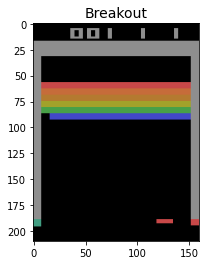

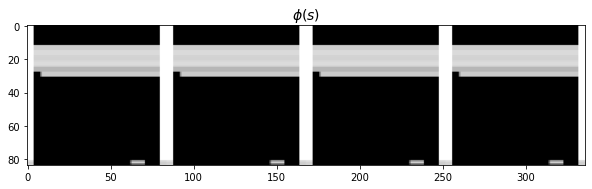

In [5]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(200):
    obs, _, _, _ = env.step(env.action_space.sample())
    
plt.title("Breakout",fontsize=14)            
plt.imshow(env.render("rgb_array"))
plt.savefig("breakout.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))
plt.title(r"$\phi(s)$",fontsize=14)
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]),cmap="gray");
plt.savefig("phi2.pdf",bbox_inches='tight')